The goal of this notebook is to attempt to predict the causes of wildfires given data on its location, its size, and the discovery date. I will use the previous notebook on the exploratory analysis to select the variables that will be used in different machine learing algorithms.

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")


# Connect to the database and import the table 'Fires'
import os
import sqlite3

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


conn = sqlite3.connect('/kaggle/input/us-wildfire-records-6th-edition/data.sqlite') 
df = pd.read_sql_query('SELECT * FROM Fires;', con=conn)

# Close connection
conn.close()

# Select only columns of interest
col_of_interest = ['OBJECTID', 'FIRE_YEAR', 'DISCOVERY_DATE', 'DISCOVERY_DOY', 'NWCG_GENERAL_CAUSE', 'FIRE_SIZE', 'FIRE_SIZE_CLASS', 'LATITUDE' , 'LONGITUDE' , 'STATE']
df = df[col_of_interest].set_index('OBJECTID', verify_integrity = True)

# Rename the columns and the index
df = df.rename(columns = {'FIRE_YEAR':'fire_year',
                         'DISCOVERY_DATE':'disc_date',
                         'DISCOVERY_DOY':'disc_doy',
                         'NWCG_GENERAL_CAUSE':'cause',
                         'FIRE_SIZE' : 'fire_size',
                         'FIRE_SIZE_CLASS' : 'fire_class',
                         'LATITUDE':'latitude',
                         'LONGITUDE':'longitude',
                         'STATE':'state'}).rename_axis('id')

# Convert the columns 'disc_date' in datetime format and add a colmun with the month
df['disc_date'] = pd.to_datetime(pd.to_datetime(df['disc_date'], format = '%m/%d/%Y').dt.strftime('%Y-%m-%d'))
df.insert(3, 'disc_month', df['disc_date'].dt.month)
df.insert(4, 'disc_day', df['disc_date'].dt.day_name())

# Define a new column 'origin'
map_cause = {'Power generation/transmission/distribution':'Accidental',
            'Natural':'Natural',
            'Debris and open burning':'Accidental',
            'Missing data/not specified/undetermined':'Undefined',
            'Recreation and ceremony':'Accidental',
            'Equipment and vehicle use':'Accidental',
            'Arson/incendiarism':'Criminal',
            'Fireworks':'Accidental',
            'Other causes':'Accidental',
            'Railroad operations and maintenance':'Accidental',
            'Smoking':'Accidental',
            'Misuse of fire by a minor':'Accidental',
            'Firearms and explosives use':'Accidental'}

df['origin'] = df['cause'].map(map_cause)

# For the analysis, we focus on the contiguous USA and define four main geographic area
df = df.loc[(df['latitude']>=25) & (df['latitude']<=50)]

df.head()

/kaggle/input/us-wildfire-records-6th-edition/_variable_descriptions.csv
/kaggle/input/us-wildfire-records-6th-edition/data.sqlite
/kaggle/input/us-wildfire-records-6th-edition/data.csv


,fire_year,disc_date,disc_doy,disc_month,disc_day,cause,fire_size,fire_class,latitude,longitude,state,origin
id,,,,,,,,,,,,
1,2005,2005-02-02,33,2,Wednesday,Power generation/transmission/distribution,0.10,A,40.036944,-121.005833,CA,Accidental
2,2004,2004-05-12,133,5,Wednesday,Natural,0.25,A,38.933056,-120.404444,CA,Natural
3,2004,2004-05-31,152,5,Monday,Debris and open burning,0.10,A,38.984167,-120.735556,CA,Accidental
4,2004,2004-06-28,180,6,Monday,Natural,0.10,A,38.559167,-119.913333,CA,Natural
5,2004,2004-06-28,180,6,Monday,Natural,0.10,A,38.559167,-119.933056,CA,Natural


# 1. Selection of variables and feature engineering

We know that the cause of wildfire varies largely across states. For the spatial dimension, I will use latitude and longitude coordinates because they provide a finest resolution than states.

For the temporal dimension, I will use day of week, the month and, of course, the year. For month, I will use them their names rather than numbers to avoid to have a hirarchical relationship between them.



In [2]:
df['disc_month'] = df['disc_date'].dt.month_name()

Finally, I have to decide either 'fire_size' or 'fire_class' to be used.

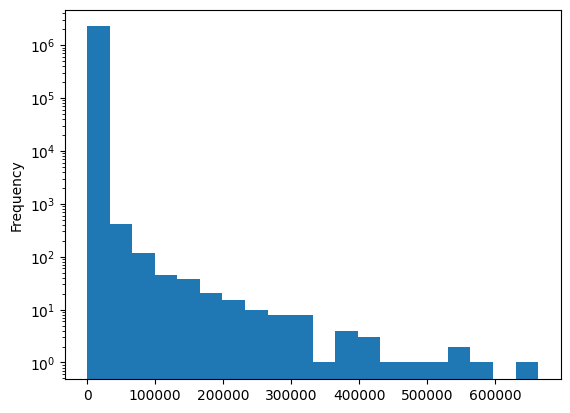

In [3]:
df['fire_size'].plot(kind = 'hist', bins = 20, log = True);

The distribution of 'fire_size' is unbalanced toward small values. As this could be problematic for the machine learing, I will use 'fire_class' instead.

In [4]:
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split

# target versus features
labels = df['cause']
features = df.drop(columns = ['disc_date', 'disc_doy', 'cause', 'fire_size', 'state', 'origin'])

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size = 0.2, random_state = 42)

# Encoding the target
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

# Encoding features
num_features = ['fire_year', 'latitude', 'longitude']
cat_features = ['disc_month', 'disc_day', 'fire_class']

num_train = X_train[num_features]
num_test = X_test[num_features]
cat_train = X_train[cat_features]
cat_test = X_test[cat_features]

ode = OrdinalEncoder()
cat_train_encoded = ode.fit_transform(cat_train)
cat_test_encoded = ode.transform(cat_test)

X_train = np.concatenate([num_train, cat_train_encoded], axis=1)
X_test = np.concatenate([num_test, cat_test_encoded], axis=1)

print("Train subset dimensions:", X_train.shape)
print("Test subset dimensions:", X_test.shape)

Train subset dimensions: (1804724, 6)
Test subset dimensions: (451181, 6)


# 2. Machine Learning

For this project I plan to train only a Random Forest that is a collaborative team of decision trees that work together to provide a single output. Tree-based algorithms do not require any normalization compared to others surpervised machine learning method because they are not sensitive to feature scalin, making them particularly suitable for this project. Indeed, we are dealing here with coordinates and temoporal data that, although numeric, are not quantitative. One way to bypass this issue to train other models would be to convert the latitude and longitude to radians instead of degrees and to encode time-related information to dummy variables.

In [6]:
from sklearn.ensemble import RandomForestClassifier

clf_rf = RandomForestClassifier(n_jobs=-1, n_estimators=50)
clf_rf.fit(X_train, y_train)

print('Score on train subset:', clf_rf.score(X_train, y_train))
print('Score on test subset:', clf_rf.score(X_test, y_test))

Score on train subset: 0.9983931060926767
Score on test subset: 0.5665353815874339


The score (accuracy) for the train subset is largely higher than for the test subset, indicating that the model is clearly overfitted and is not adapted for new data.

In [22]:
# Search for better parameters

from sklearn.model_selection import GridSearchCV

clf_rf = RandomForestClassifier(n_jobs=-1, n_estimators=50)

params = {'min_samples_leaf' : [50, 500], 'max_depth' : [50, 200]}
grid = GridSearchCV(estimator = clf_rf, param_grid = params)
grille = grid.fit(X_train, y_train)

print("Best params", grille.best_params_)

print(grille.score(X_train, y_train))
print(grille.score(X_test, y_test))

Best params {'max_depth': 200, 'min_samples_leaf': 50}
0.5635692770750541
0.546459181570146


Increasing 'min_samples_leaf' and 'max_depth' parameters significantly enhances the ability of the model to generalize its predictions, while 'n_estimators' doesn't seem to have a strong effet on performances (tests performed on my own machine).

In [26]:
from sklearn.metrics import classification_report

y_pred_rf = grille.predict(X_test)

print(classification_report(y_test, 
                            y_pred_rf,
                            target_names=le.inverse_transform(np.arange(labels.nunique()))
                           )
     )

                                            precision    recall  f1-score   support

                        Arson/incendiarism       0.55      0.45      0.49     64177
                   Debris and open burning       0.49      0.72      0.58    106931
                 Equipment and vehicle use       0.44      0.15      0.23     37887
               Firearms and explosives use       0.93      0.29      0.44       505
                                 Fireworks       0.56      0.24      0.33      3751
   Missing data/not specified/undetermined       0.58      0.68      0.62    112527
                 Misuse of fire by a minor       0.45      0.04      0.07     13157
                                   Natural       0.64      0.80      0.71     64200
                              Other causes       0.55      0.01      0.01      2051
Power generation/transmission/distribution       0.65      0.01      0.01      6404
       Railroad operations and maintenance       0.45      0.33      0.38  

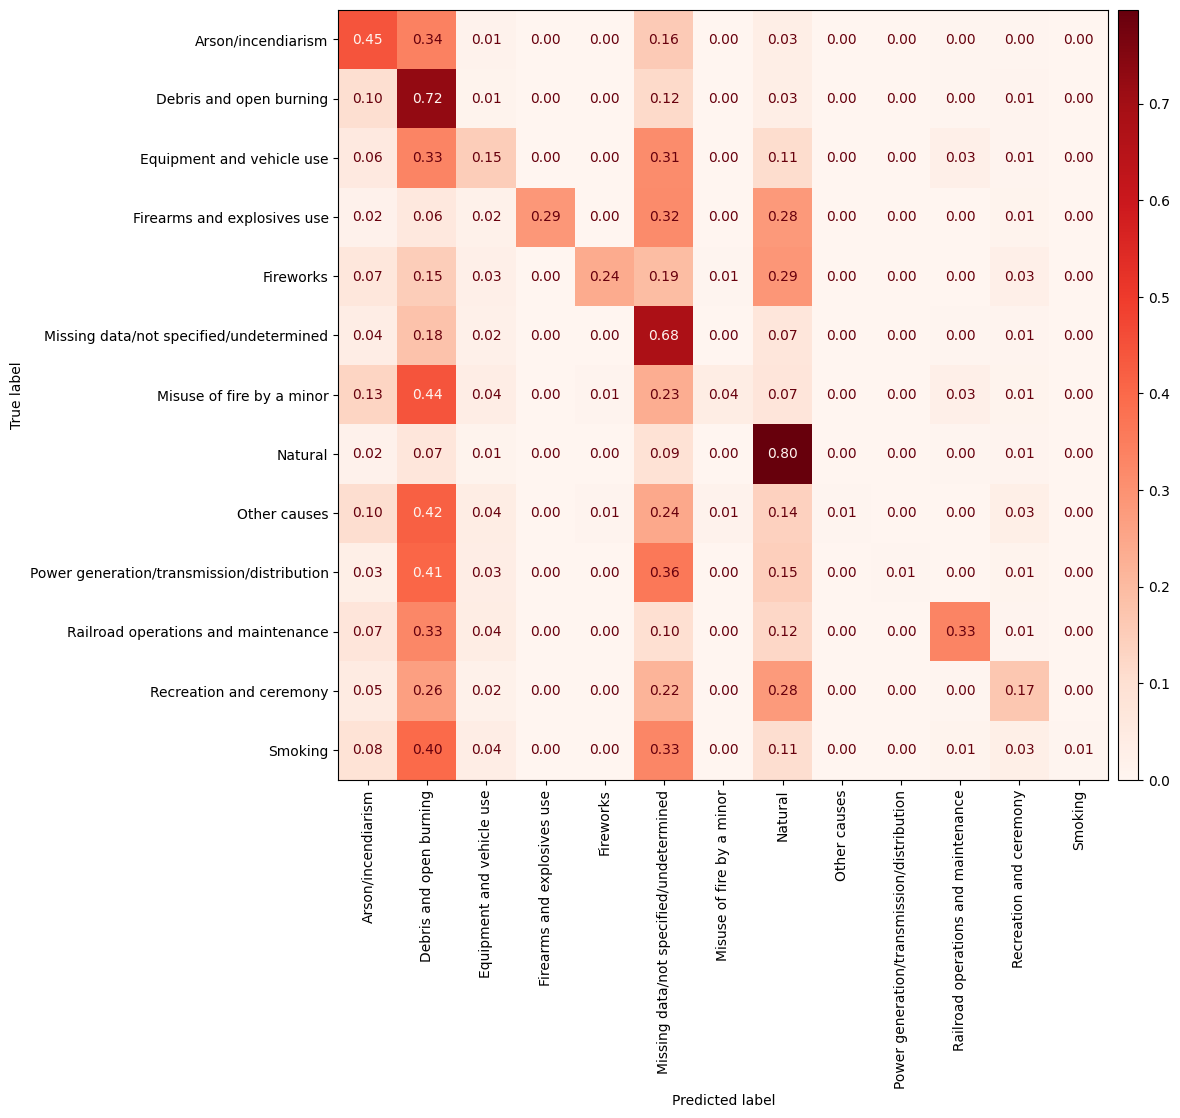

In [27]:
from sklearn.metrics import ConfusionMatrixDisplay

fig, ax = plt.subplots(figsize=(10,10))

cmp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rf, 
                                              display_labels = le.inverse_transform(np.arange(labels.nunique())),
                                              normalize = 'true',
                                              xticks_rotation='vertical',
                                              cmap=plt.cm.Reds, 
                                              values_format = '.2f', 
                                              ax=ax,
                                              colorbar=False)

cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
plt.colorbar(cmp.im_,  cax=cax);

Precision and recall scores are highly variable across the causes. Overall, precision is higher than recall, expect for some causes such as Natural, meaning that the model fails to detect correct causes. Only Natural, Debris and open burning, and undetermined (well, not very usefull) wildfires can be reasonnably predict. 

One of the reason is that large number of causes and that fact their distribution is largely unbalanced.

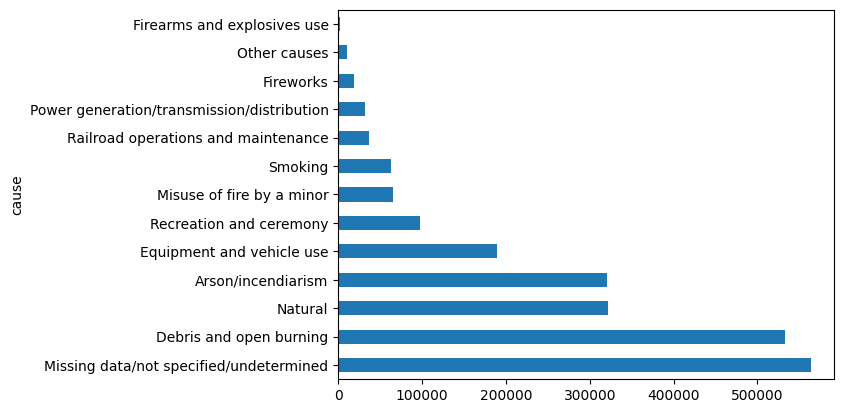

In [35]:
df.cause.value_counts().plot.barh();

**Conclusion:**


I also aimed to optimize this classifier, using GridSearchCV, and found the following parameters : [min_samples_leaf=10, max_depth=120, n_estimators=320, criterion = 'entropy']. Yet, the gain in terms of prediction was only about 0.2-0.3% but the time of execution increased largely much from minutes to hours, making this optimization not worthy.